# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 36kB/s  eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

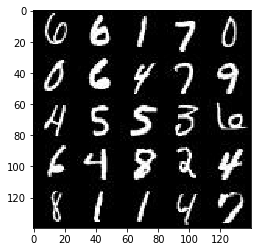

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

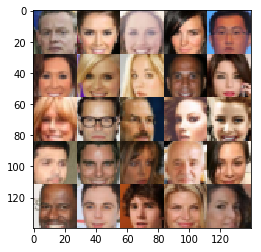

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    learning_rate = tf.placeholder(tf.float32, name='learning_rate', shape=())
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        
        #logits
        logits = tf.layers.dense(flat, 1)
        
        #output
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = True
    alpha=0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 3, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 3, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 3, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [16]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth=0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [17]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [19]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    _, img_width, img_height, img_channels = data_shape
    input_real, input_z, _ = model_inputs(img_width, img_height, img_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    steps = 0
    images_to_show = 25
    losses = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images = batch_images * 2
                steps += 1
            
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                #print("batch images {}...".format(batch_size))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if steps % 100 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                if steps % 100 == 0:
                    _ = show_generator_output(sess, images_to_show, input_z, img_channels, data_image_mode)
    return losses
                
              

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.0051... Generator Loss: 0.2464


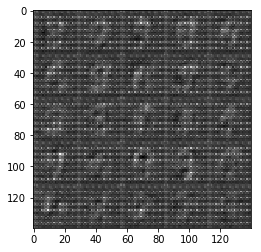

Epoch 1/2... Discriminator Loss: 0.9390... Generator Loss: 2.0037


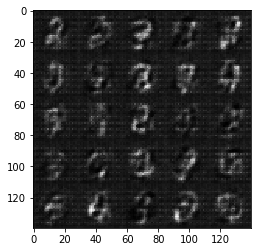

Epoch 1/2... Discriminator Loss: 0.9471... Generator Loss: 1.6651


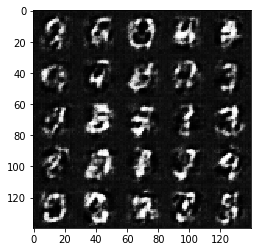

Epoch 1/2... Discriminator Loss: 0.9494... Generator Loss: 1.1652


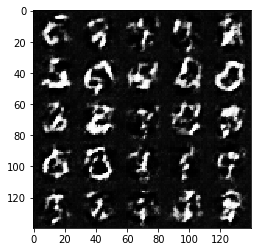

Epoch 1/2... Discriminator Loss: 0.9990... Generator Loss: 1.4421


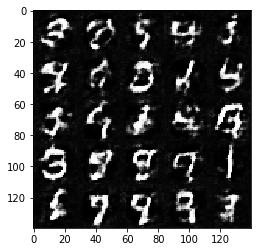

Epoch 1/2... Discriminator Loss: 0.9522... Generator Loss: 1.0238


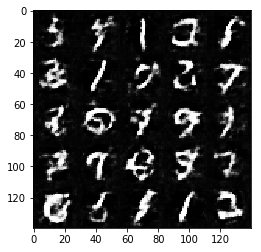

Epoch 1/2... Discriminator Loss: 1.0837... Generator Loss: 1.1290


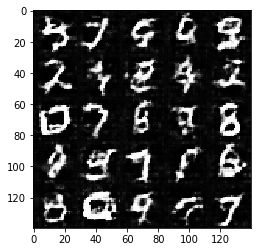

Epoch 1/2... Discriminator Loss: 1.9257... Generator Loss: 0.4703


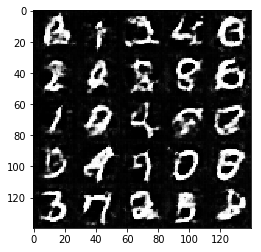

Epoch 1/2... Discriminator Loss: 1.1590... Generator Loss: 0.7646


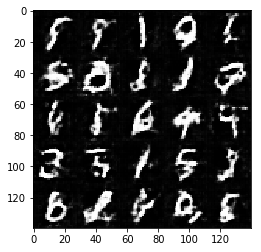

Epoch 1/2... Discriminator Loss: 1.5219... Generator Loss: 0.4082


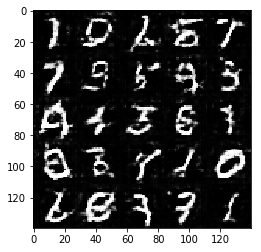

Epoch 1/2... Discriminator Loss: 1.0522... Generator Loss: 0.8703


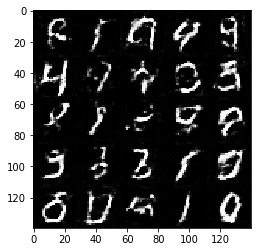

Epoch 1/2... Discriminator Loss: 1.6829... Generator Loss: 0.3361


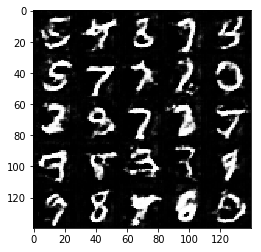

Epoch 1/2... Discriminator Loss: 1.8496... Generator Loss: 0.3083


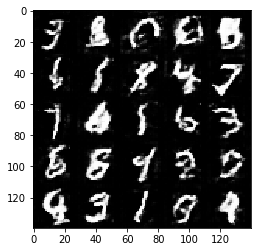

Epoch 1/2... Discriminator Loss: 1.0283... Generator Loss: 0.8127


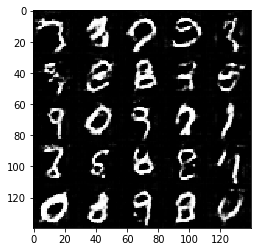

Epoch 1/2... Discriminator Loss: 1.7340... Generator Loss: 0.3547


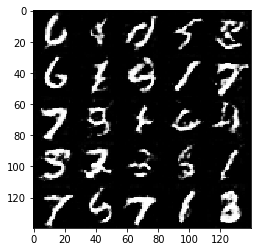

Epoch 1/2... Discriminator Loss: 1.1731... Generator Loss: 0.6734


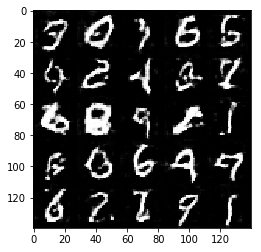

Epoch 1/2... Discriminator Loss: 0.7957... Generator Loss: 1.1934


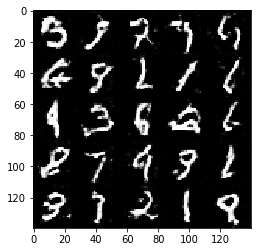

Epoch 1/2... Discriminator Loss: 0.9074... Generator Loss: 1.2383


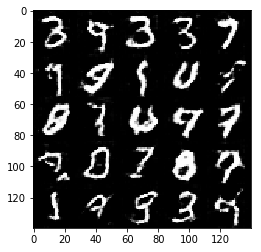

Epoch 2/2... Discriminator Loss: 0.9422... Generator Loss: 0.8982


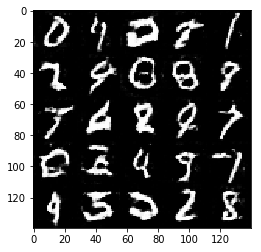

Epoch 2/2... Discriminator Loss: 0.9411... Generator Loss: 0.9478


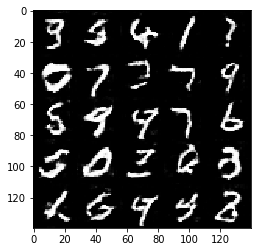

Epoch 2/2... Discriminator Loss: 1.1000... Generator Loss: 0.7768


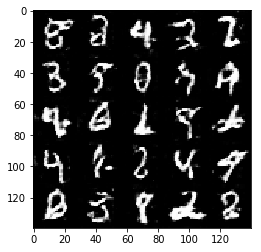

Epoch 2/2... Discriminator Loss: 1.4270... Generator Loss: 0.4694


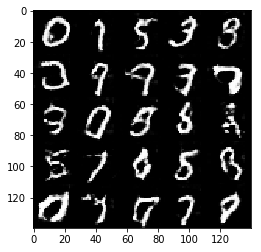

Epoch 2/2... Discriminator Loss: 0.9427... Generator Loss: 0.8992


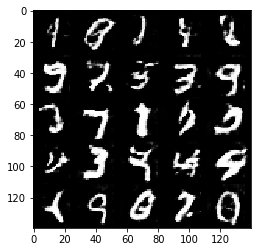

Epoch 2/2... Discriminator Loss: 0.9608... Generator Loss: 0.9184


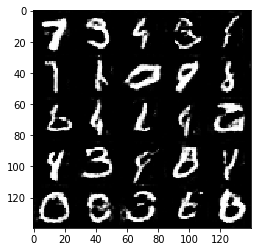

Epoch 2/2... Discriminator Loss: 0.7826... Generator Loss: 1.4635


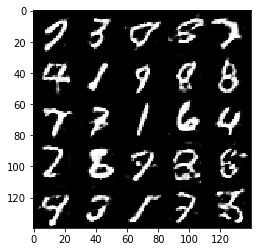

Epoch 2/2... Discriminator Loss: 1.1078... Generator Loss: 0.7355


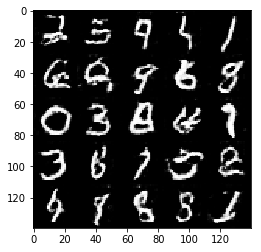

Epoch 2/2... Discriminator Loss: 1.3552... Generator Loss: 0.6583


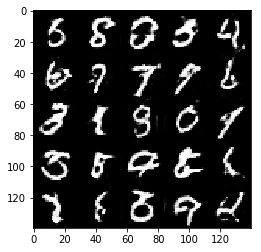

Epoch 2/2... Discriminator Loss: 0.8514... Generator Loss: 1.4165


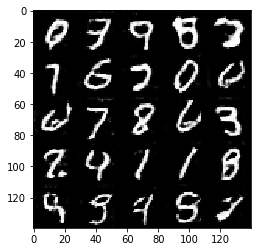

Epoch 2/2... Discriminator Loss: 1.2390... Generator Loss: 0.6088


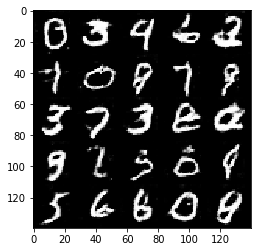

Epoch 2/2... Discriminator Loss: 1.1005... Generator Loss: 0.7230


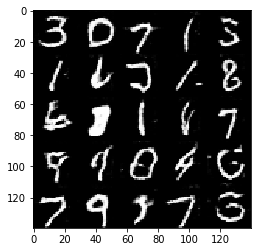

Epoch 2/2... Discriminator Loss: 0.9067... Generator Loss: 2.3311


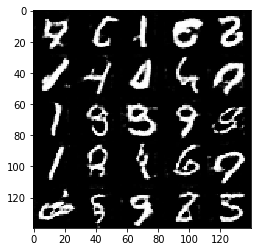

Epoch 2/2... Discriminator Loss: 1.6825... Generator Loss: 3.2781


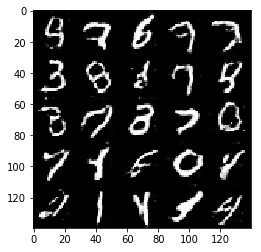

Epoch 2/2... Discriminator Loss: 1.2357... Generator Loss: 0.6521


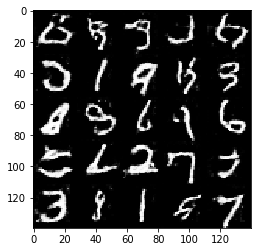

Epoch 2/2... Discriminator Loss: 0.8532... Generator Loss: 1.5320


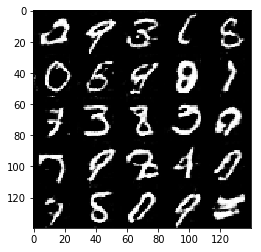

Epoch 2/2... Discriminator Loss: 0.9053... Generator Loss: 2.5605


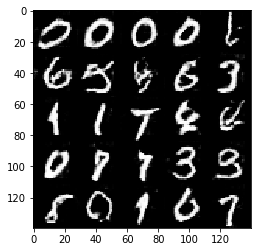

Epoch 2/2... Discriminator Loss: 1.1113... Generator Loss: 0.7641


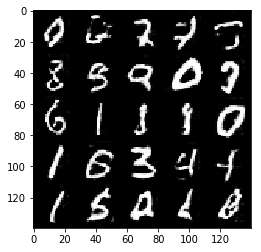

Epoch 2/2... Discriminator Loss: 1.1610... Generator Loss: 0.6536


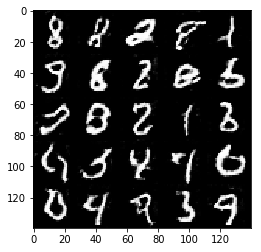

In [24]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.13



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    losses = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

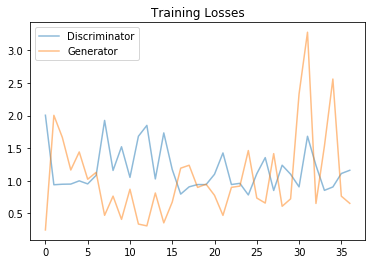

In [25]:
%matplotlib inline

import pickle as pkl
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.3230... Generator Loss: 0.7718


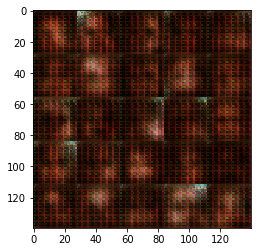

Epoch 1/1... Discriminator Loss: 1.4691... Generator Loss: 0.5718


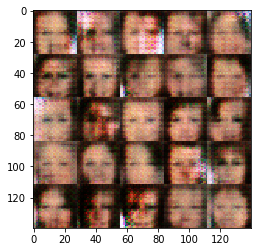

Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.8836


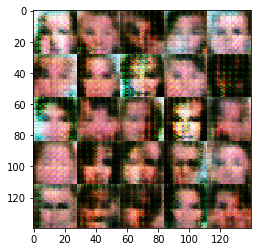

Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.8591


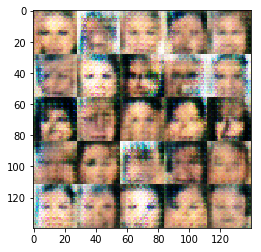

Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.9366


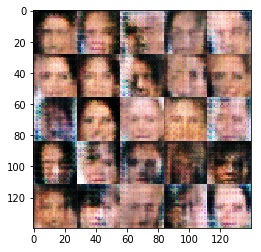

Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.7927


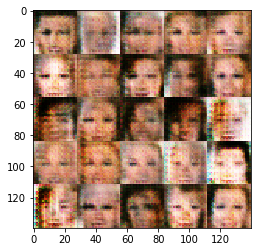

Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.7723


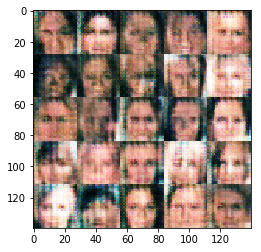

Epoch 1/1... Discriminator Loss: 1.4275... Generator Loss: 0.6509


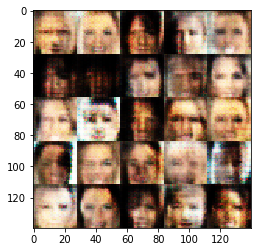

Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.8978


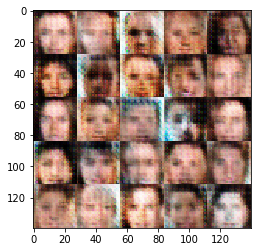

Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.7274


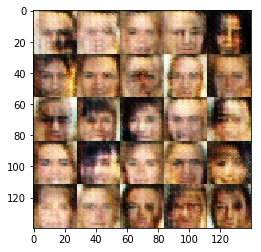

Epoch 1/1... Discriminator Loss: 1.4351... Generator Loss: 0.7510


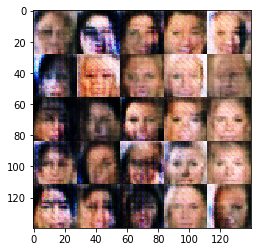

Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.7734


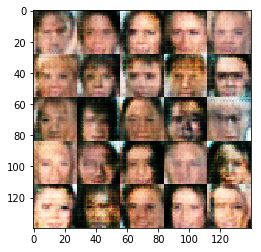

Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.7199


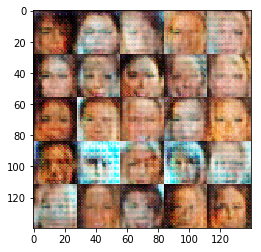

Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.6977


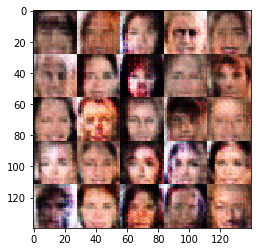

Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.7142


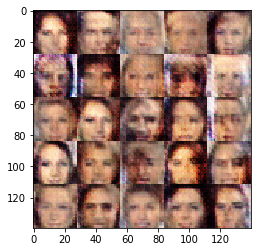

Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.8258


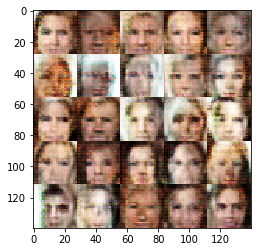

Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.8076


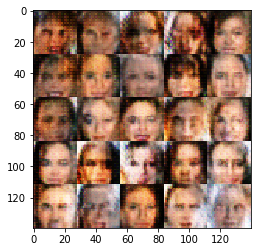

Epoch 1/1... Discriminator Loss: 1.3694... Generator Loss: 0.7758


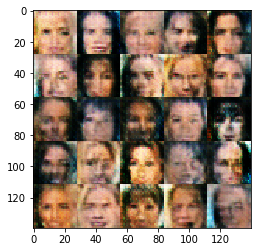

Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.8138


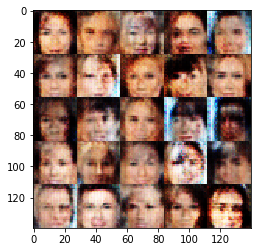

Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.8222


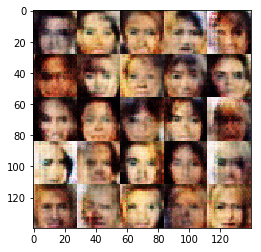

Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.8379


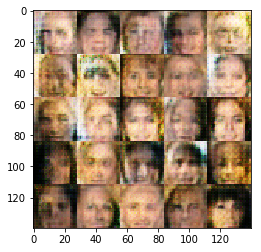

Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 0.8332


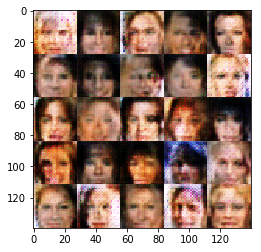

Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.8062


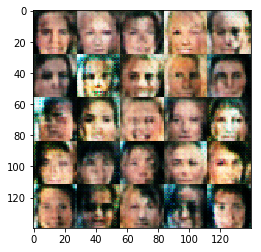

Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 0.8037


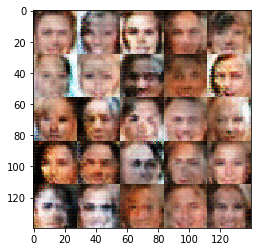

Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.8663


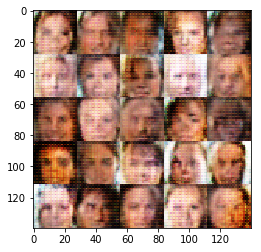

Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.7937


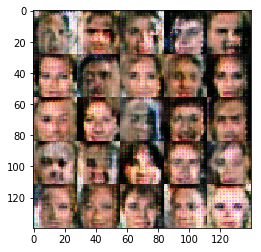

Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.7690


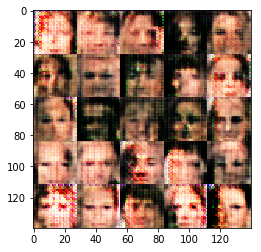

Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.7626


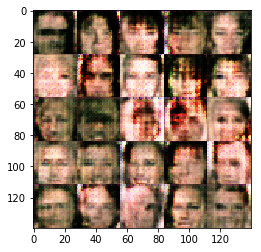

Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.7648


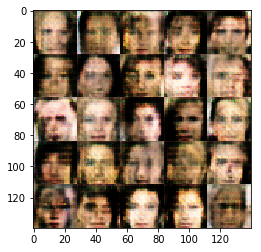

Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.7747


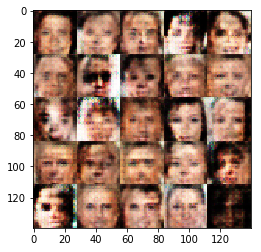

Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.7976


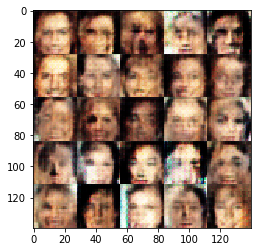

Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.7448


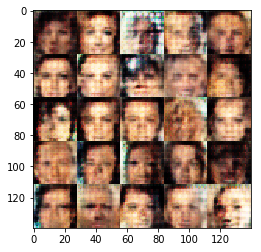

Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.8072


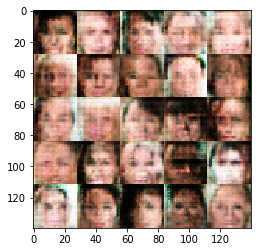

Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.7976


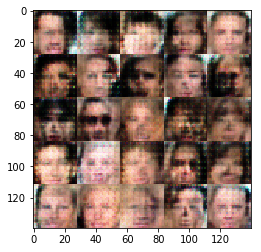

Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.7141


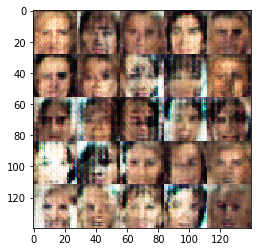

Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.7722


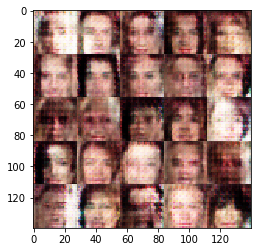

Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.7784


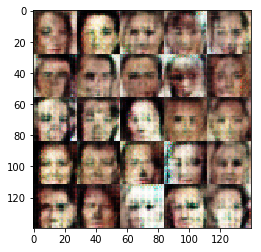

Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.8045


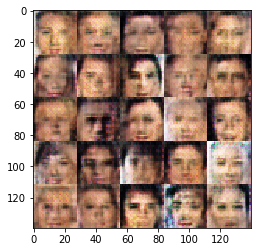

Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.7564


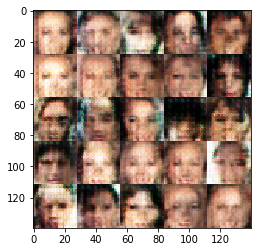

Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.7729


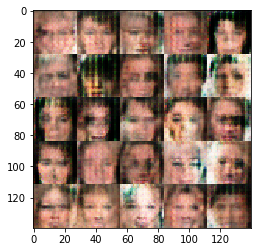

Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 0.7833


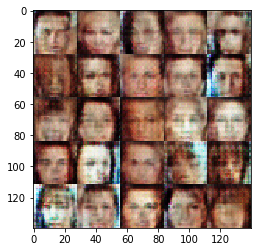

Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.7945


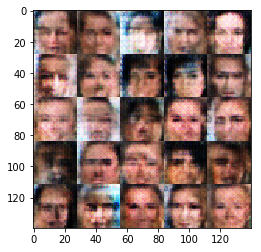

Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.8056


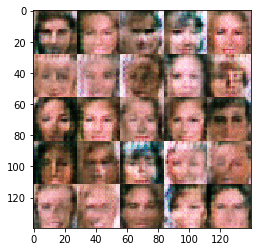

Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.7424


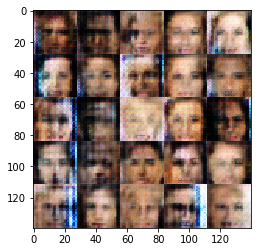

Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.7929


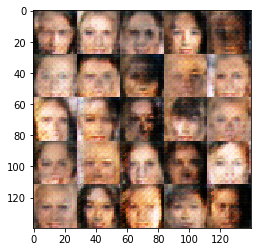

Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.8033


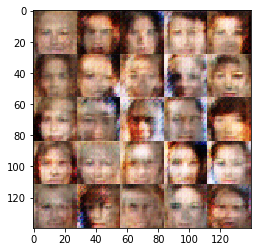

Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.7934


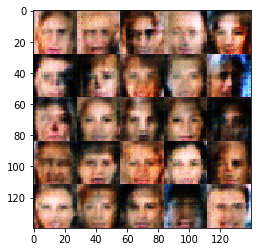

Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 0.7592


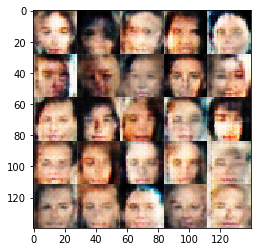

Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.7732


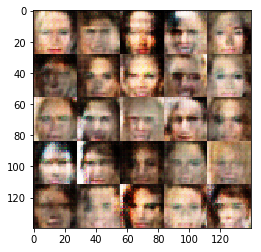

Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.7886


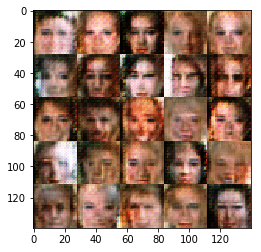

Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.8054


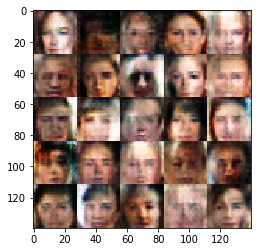

Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.8030


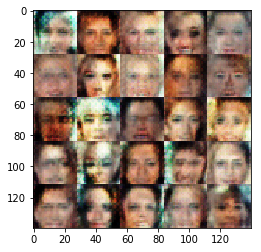

Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.8541


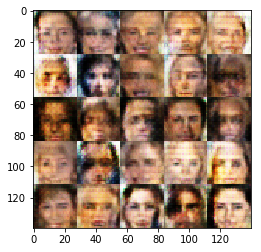

Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.8286


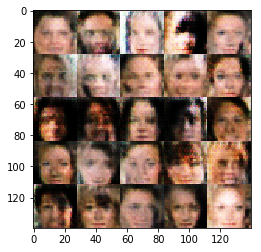

Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.7860


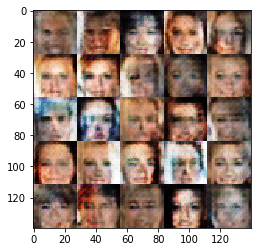

Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.8012


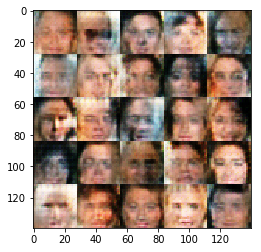

Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.7897


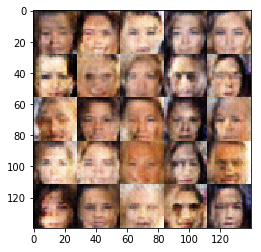

Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.7953


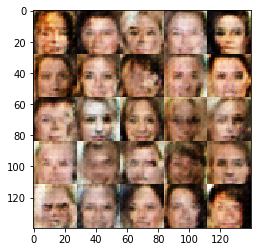

Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.7800


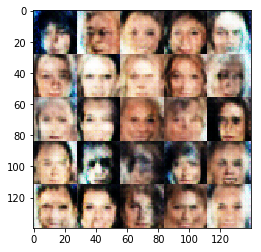

Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.8209


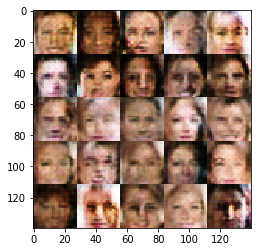

Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.7882


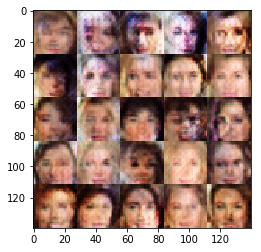

Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.7961


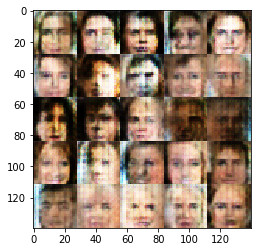

Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.7881


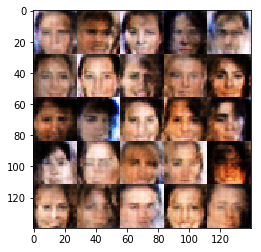

In [27]:
batch_size = batch_size
z_dim = z_dim
learning_rate = 0.003
beta1 = beta1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.